In [ ]:
#importing libraries
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import os
import random
import pandas as pd
import glob
import matplotlib.pyplot as plt


In [ ]:
!pip install --upgrade torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
pip install tqdm


In [ ]:
from tqdm import tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
#class for creating data loaders

class VideoDataset(Dataset):
    def __init__(self, video_names, labels, sequence_length=60, transform=None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100 / self.count)
        first_frame = np.random.randint(0, a)
        temp_video = os.path.basename(video_path)
        label = self.labels.loc[self.labels["FileName"] == temp_video, "label"].item()
        label = 0 if label == 'FAKE' else 1

        for i, frame in enumerate(self.frame_extract(video_path)):
            frames.append(self.transform(frame))
            if len(frames) == self.count:
                break
        frames = torch.stack(frames)
        frames = frames[:self.count]

        return frames, label

    def frame_extract(self, path):
        vidObj = cv2.VideoCapture(path)
        success = 1
        while success:
            success, image = vidObj.read()
            if success:
                yield image

In [ ]:
#Define data processing transformation

def get_data_transforms(im_size=112):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    train_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((im_size, im_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    return train_transforms

In [ ]:
#define model class

from torch import nn
from torchvision import models
class MyModel(nn.Module):
      def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(MyModel, self).__init__()
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
      def forward(self, x):
          batch_size,seq_length, c, h, w = x.shape
          x = x.view(batch_size * seq_length, c, h, w)
          fmap = self.model(x)
          x = self.avgpool(fmap)
          x = x.view(batch_size,seq_length,2048)
          x_lstm,_ = self.lstm(x,None)
          return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))


In [ ]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
#method to train model

def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []

    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _, outputs = model(inputs)
        loss = criterion(outputs, targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
            % (
                epoch,
                num_epochs,
                i,
                len(data_loader),
                losses.avg,
                accuracies.avg))
    torch.save(model.state_dict(), '/content/checkpoint.pt')
    return losses.avg, accuracies.avg


In [ ]:
#method for testing model
def test_epoch(epoch, model, data_loader, criterion):
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _, outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
            _, p = torch.max(outputs, 1)
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                % (
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg
                )
            )

        print('\nAccuracy {}'.format(accuracies.avg))
    return true, pred, losses.avg, accuracies.avg


In [ ]:
#importing training data and label file


def load_data():
    header_list = ["FileName", "label","Dataset"]
    labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deepfake Detection Project/files/modifed_Files.csv', names=header_list)

    video_files = glob.glob('/content/drive/MyDrive/Colab Notebooks/realface_only_data/Celeb-DF_fake/*.mp4')
    video_files += glob.glob('/content/drive/MyDrive/Colab Notebooks/realface_only_data/Celeb-DF_real/*.mp4')
    video_files += glob.glob('/content/drive/MyDrive/Colab Notebooks/realface_only_data/DFD_fake/*.mp4')
    video_files += glob.glob('/content/drive/MyDrive/Colab Notebooks/realface_only_data/DFD_real/*.mp4')
    video_files += glob.glob('/content/drive/MyDrive/Colab Notebooks/realface_only_data/FF_fake/*.mp4')
    video_files += glob.glob('/content/drive/MyDrive/Colab Notebooks/realface_only_data/FF_real/*.mp4')

    random.shuffle(video_files)
    random.shuffle(video_files)

    frame_count = []
    valid_video_files = []

    for video_file in video_files:
        cap = cv2.VideoCapture(video_file)
        if int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) >= 100:
            frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
            valid_video_files.append(video_file)

    return labels, valid_video_files

In [ ]:
#calculate average
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
import seaborn as sn

#methods for accuracy, confusion matrix etc.
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['FAKE', 'REAL'], size = 16)
    plt.yticks(np.arange(2), ['FAKE', 'REAL'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 80.1MB/s]
Training Progress:   0%|          | 0/8 [00:00<?, ?it/s]

[Batch 139 / 140]  [Loss: 0.401064, Acc: 80.79%]

Training Progress:  12%|█▎        | 1/8 [01:54<13:19, 114.22s/it, test_acc=80.8, test_loss=0.401, train_acc=64.6, train_loss=0.625]


Accuracy 80.78994614003591
[Batch 138 / 140]  [Loss: 0.293586, Acc: 88.31%]

Training Progress:  25%|██▌       | 2/8 [03:53<11:44, 117.48s/it, test_acc=88.3, test_loss=0.294, train_acc=82.1, train_loss=0.478]

[Batch 139 / 140]  [Loss: 0.293961, Acc: 88.33%]
Accuracy 88.33034111310593
[Batch 136 / 140]  [Loss: 0.250219, Acc: 92.34%]

Training Progress:  38%|███▊      | 3/8 [05:52<09:50, 118.04s/it, test_acc=91.9, test_loss=0.257, train_acc=85.4, train_loss=0.425]

[Batch 139 / 140]  [Loss: 0.257454, Acc: 91.92%]
Accuracy 91.92100538599641
[Batch 137 / 140]  [Loss: 0.257662, Acc: 91.12%]

Training Progress:  50%|█████     | 4/8 [07:50<07:51, 117.84s/it, test_acc=91.2, test_loss=0.257, train_acc=88.8, train_loss=0.369]

[Batch 139 / 140]  [Loss: 0.256538, Acc: 91.20%]
Accuracy 91.20287253141831
[Batch 135 / 140]  [Loss: 0.226851, Acc: 92.10%]

Training Progress:  62%|██████▎   | 5/8 [09:48<05:53, 117.86s/it, test_acc=92.3, test_loss=0.224, train_acc=90.8, train_loss=0.333]

[Batch 139 / 140]  [Loss: 0.223787, Acc: 92.28%]
Accuracy 92.28007181328546
[Batch 139 / 140]  [Loss: 0.225016, Acc: 91.38%]

Training Progress:  75%|███████▌  | 6/8 [11:47<03:56, 118.38s/it, test_acc=91.4, test_loss=0.225, train_acc=90.1, train_loss=0.33]


Accuracy 91.38240574506284
[Batch 134 / 140]  [Loss: 0.245657, Acc: 90.93%]

Training Progress:  88%|████████▊ | 7/8 [13:46<01:58, 118.66s/it, test_acc=90.8, test_loss=0.245, train_acc=90.6, train_loss=0.317]

[Batch 139 / 140]  [Loss: 0.244922, Acc: 90.84%]
Accuracy 90.84380610412926
[Batch 138 / 140]  [Loss: 0.207850, Acc: 93.17%]

Training Progress: 100%|██████████| 8/8 [15:44<00:00, 118.05s/it, test_acc=93.2, test_loss=0.208, train_acc=93.9, train_loss=0.264]

[Batch 139 / 140]  [Loss: 0.207838, Acc: 93.18%]
Accuracy 93.17773788150808
8


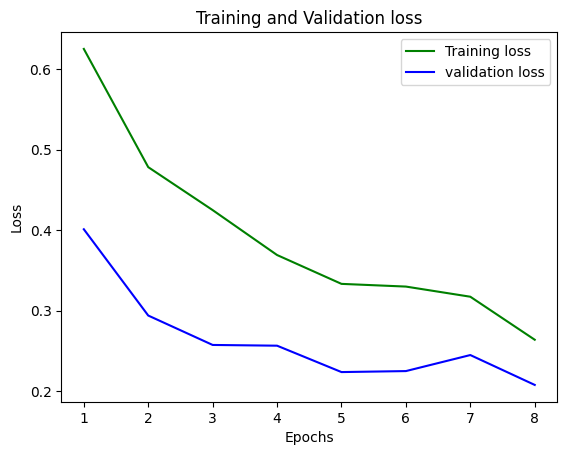

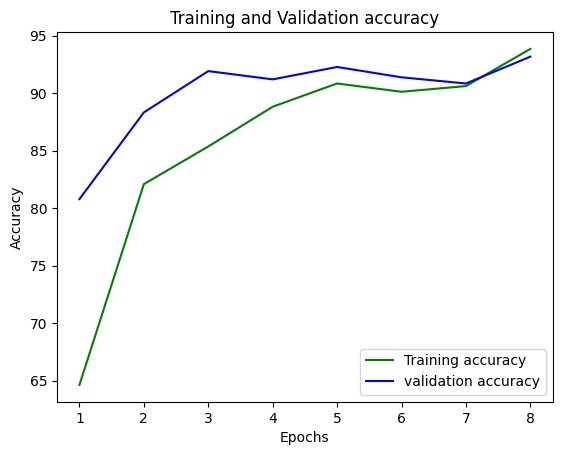

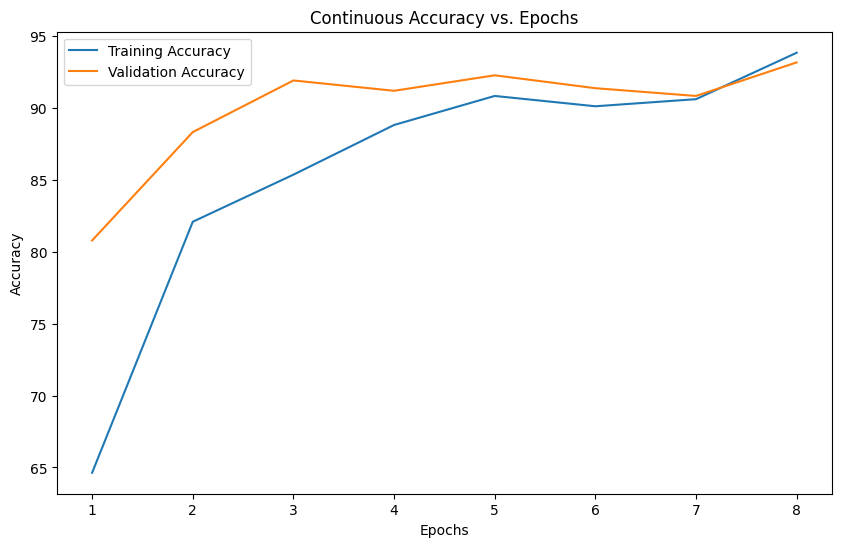

[[300  11]
 [ 27 219]]
True positive =  300
False positive =  11
False negative =  27
True negative =  219




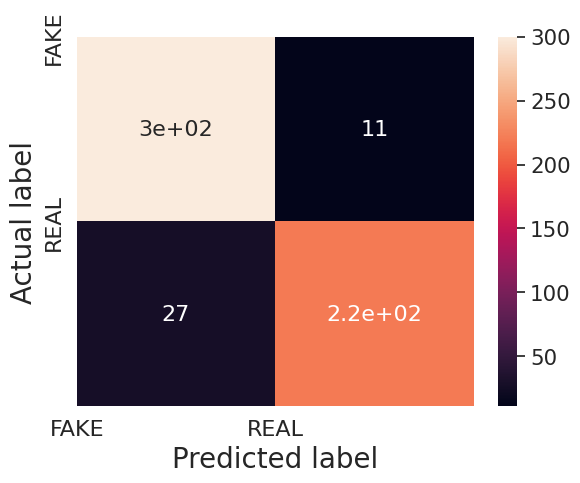

Calculated Accuracy 93.17773788150808


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

if __name__ == '__main__':
    # Set device and other configurations

    # Data preprocessing transforms
    data_transforms = get_data_transforms()

    # Load labels and video files
    labels, video_files = load_data()

    # Split the data into train and validation sets
    train_ratio = 0.8
    split_index = int(train_ratio * len(video_files))
    train_videos = video_files[:split_index]
    valid_videos = video_files[split_index:]

    # Create data loaders
    train_data = VideoDataset(train_videos, labels, sequence_length=10, transform=data_transforms)
    train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
    valid_data = VideoDataset(valid_videos, labels, sequence_length=10, transform=data_transforms)
    valid_loader = DataLoader(valid_data, batch_size=4, shuffle=True, num_workers=2)

    # Define the model
    model = MyModel(2).cuda()

    # Set hyperparameters

    # Learning rate
    lr = 1e-5  # 0.001
    # Number of epochs
    num_epochs = 8

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss().cuda()

    # Train the model and test
    train_loss_avg = []
    train_accuracy = []
    test_loss_avg = []
    test_accuracy = []
    train_accuracy_per_step = []  # Store training accuracy at each step
    test_accuracy_per_step = []  # Store validation accuracy at each step

    # Initialize tqdm
    t = tqdm(total=num_epochs, desc="Training Progress")

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(epoch, num_epochs, train_loader, model, criterion, optimizer)
        train_loss_avg.append(train_loss)
        train_accuracy.append(train_acc)
        train_accuracy_per_step.append(train_acc)  # Store accuracy at each step

        true, pred, test_loss, test_acc = test_epoch(epoch, model, valid_loader, criterion)
        test_loss_avg.append(test_loss)
        test_accuracy.append(test_acc)
        test_accuracy_per_step.append(test_acc)  # Store accuracy at each step

        t.set_postfix(train_loss=train_loss, train_acc=train_acc, test_loss=test_loss, test_acc=test_acc)
        t.update()

    t.close()

    # Plot loss and accuracy, and output confusion matrix
    plot_loss(train_loss_avg, test_loss_avg, num_epochs)
    plot_accuracy(train_accuracy, test_accuracy, num_epochs)

    # Plot continuous accuracy versus epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_accuracy_per_step, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracy_per_step, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Continuous Accuracy vs. Epochs')
    plt.legend()
    plt.show()

    print(confusion_matrix(true, pred))
    print_confusion_matrix(true, pred)


In [ ]:
torch.save(model.state_dict(),"model(1).pth")